## Data preparation

### Data loading

In [1]:
from typing import Any, Dict, Iterable, Optional, Sequence, Tuple
from re import sub
from warnings import filterwarnings
from sys import getsizeof
from pprint import PrettyPrinter
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.exceptions import NotFittedError
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from joblib import dump

RANDOM_STATE = 12345
RMSE_THRESHOLD = 2500
TRAIN_SET_SIZE = 0.6
CV_FOLDS = 2
N_ITER = 8
SCORER = "neg_root_mean_squared_error"

filterwarnings("ignore")

In [2]:
autos_data = pd.read_csv("autos.csv")

Let's make sure that we have correctly loaded data into a DataFrame.

In [3]:
autos_data.sample(7, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59


**Summary**

At this stage, we have imported all required libraries with required functions and data structures and managed to successfully read the data and correctly load it into a separate DataFrame.

### Exploring data

In [4]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We observe the following. We have data on 354,369 objects (vehicles) with various attributes and characteristics, which are of `int64` and `object` data types. We also see that the data contains information on the following 16 characteristics of automobiles:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><b>DateCrawled</b></td><td><i>Date when the data was downloaded from the database</i></td></tr>
<tr><td><b>Price</b></td><td><i>Price of a vehicle (in euros)</i></td></tr>
<tr><td><b>VehicleType</b></td><td><i>Car body type</i></td></tr>
<tr><td><b>RegistrationYear</b></td><td><i>Year of vehicle registration</i></td></tr>
<tr><td><b>Gearbox</b></td><td><i>Type of gearbox</i></td></tr>
<tr><td><b>Power</b></td><td><i>Power of a vehicle (in hp)</i></td></tr>
<tr><td><b>Model</b></td><td><i>Model of a vehicle</i></td></tr>
<tr><td><b>Kilometer</b></td><td><i>Mileage of a vehicle (in km)</i></td></tr>
<tr><td><b>RegistrationMonth</b></td><td><i>Month of vehicle registration</i></td></tr>
<tr><td><b>FuelType</b></td><td><i>Type of fuel used by a vehicle</i></td></tr>
<tr><td><b>Brand</b></td><td><i>Brand of a vehicle</i></td></tr>
<tr><td><b>Repaired</b></td><td><i>Indicator of previously performed repairs</i></td></tr>
<tr><td><b>DateCreated</b></td><td><i>Date when the data entry was created</i></td></tr>
<tr><td><b>Number of Pictures</b></td><td><i>Number of photos of a vehicle available</i></td></tr>
<tr><td><b>PostalCode</b></td><td><i>User's postal code</i></td></tr>
<tr><td><b>LastSeen</b></td><td><i>Date of a user's last activity</i></td></tr>
</tbody>
</table>

Furthermore, the presence of missing values in the data is clearly traced, which will have to be dealt with at the stage of data preprocessing. We also see that the column names do not correspond to the standard of column names, which can be handled efficiently and quickly, which will be shown in the preprocessing section.

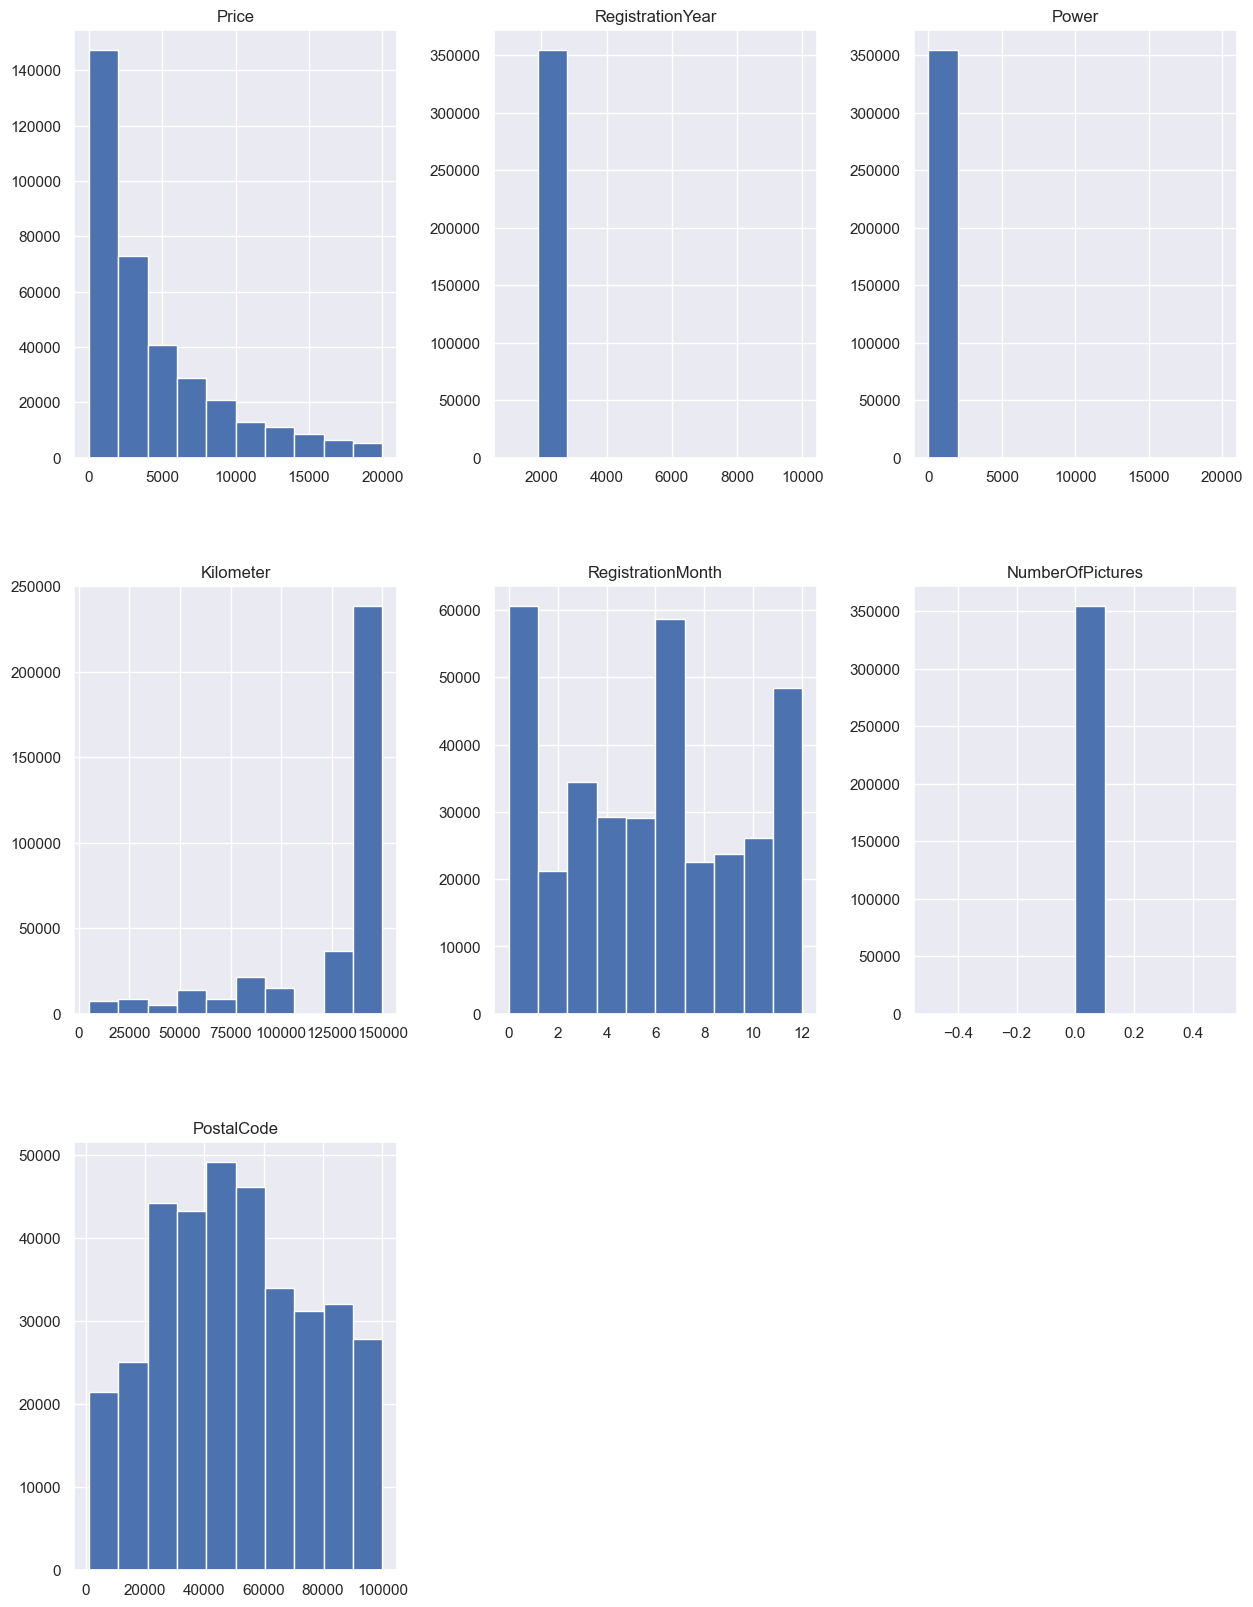

In [5]:
# Visualization of numeric columns
sns.set_theme(style="darkgrid")
autos_data.hist(figsize=(15, 20))
plt.show()

In [6]:
autos_data.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.7,4514.2,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.2,90.2,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.1,189.9,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.2,37905.3,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.7,3.7,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.7,25783.1,1067.0,30165.0,49413.0,71083.0,99998.0


Perhaps the first thing that is quite visible is the presence of anomalies in the `RegistrationYear` column, since it contains the values of the registration year that are either too high or too low to be true. Anomalies are also visible in the `Price` column (a large number of zero prices), `RegistrationMonth` (presence of 13 months, instead of 12), as well as `Power` (zero power for most objects).

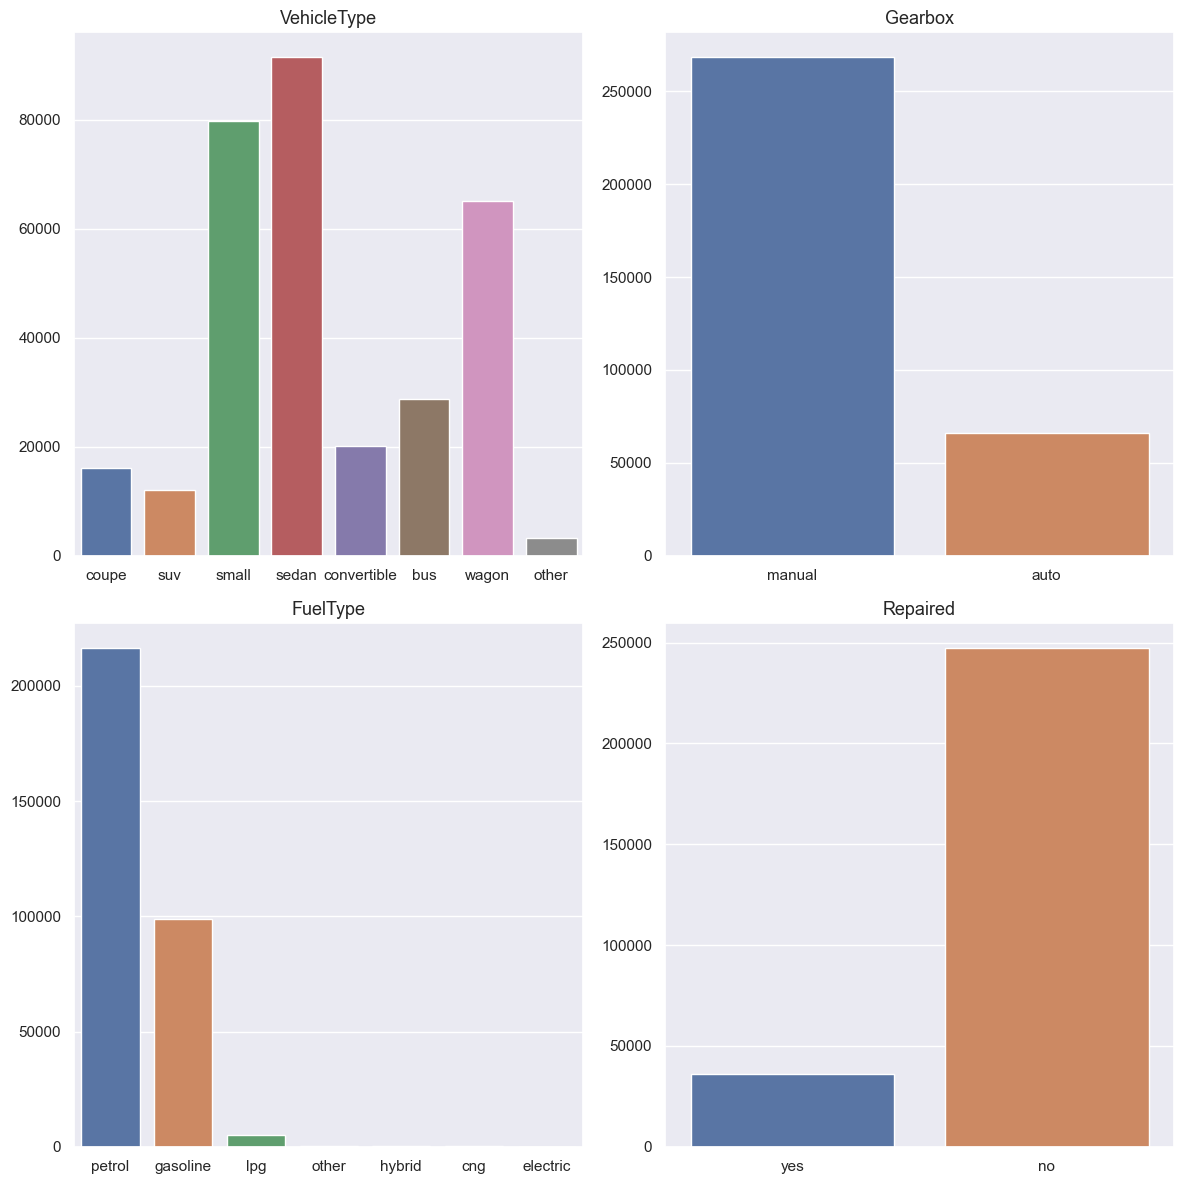

In [7]:
# Selecting categorical columns with less than 10 unique values
cat_cols = autos_data.select_dtypes(include="object").columns.to_list()
cat_cols_to_plot = [col for col in cat_cols if len(autos_data[col].unique()) < 10]

# Visualization of categorical columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.reshape(
    4,
)
for col, ax in zip(cat_cols_to_plot, axes):
    f = sns.countplot(data=autos_data, x=col, ax=ax)
    f.set(xlabel=None, ylabel=None)
    f.set_title(col, fontsize=13)
plt.tight_layout()
plt.show()

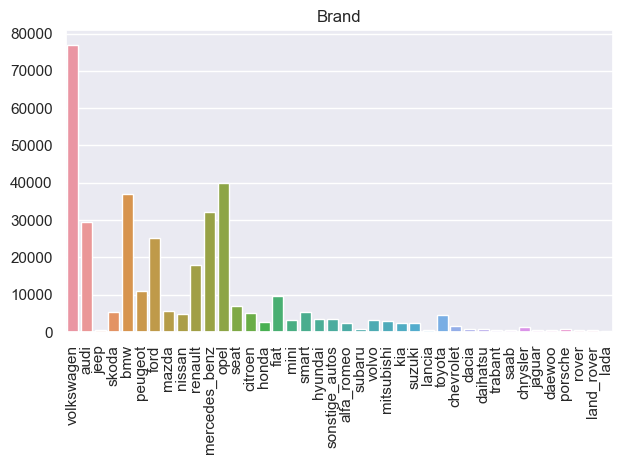

In [8]:
# Visualization of "Brand" column
fig = sns.countplot(data=autos_data, x="Brand")
fig.set(xlabel=None, ylabel=None)
plt.title("Brand")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Summary**

This stage was needed to conduct an initial review of the data, as a result of which we studied and visualized the data depending on the type of data in the DataFrame columns. We were also able to detect the presence of not only missing values, but also anomalies in some columns. We also saw that the column names can be changed for more convenient work with data.

### Data preprocessing

#### Column names

In [9]:
print(f"Old column names: {autos_data.columns.to_list()}\n")

# Changing column names to a convenient format
autos_data = autos_data.rename(
    columns=lambda col_name: sub("(?<=[a-z])(?=[A-Z])", "_", col_name).lower()
)

print(f"New column names: {autos_data.columns.to_list()}")

Old column names: ['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

New column names: ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


#### Anomalies

In order to get rid of anomalous values we can write a function called `clean_data()` that will filter the DataFrame, hence deleting anomalies.

In [10]:
def clean_data(
    data: pd.DataFrame,
    column: str,
    lower_val: int,
    upper_val: int,
    display_changes: bool = False,
) -> pd.DataFrame:
    """
    Filters out values in a specific columns
    of a DataFrame.

    Args:
        data:
            DataFrame with information on
            automobile vehicles.
        column:
            DataFrame column by which filtering
            should be done.
        lower_val:
            The lowest value of the filtering
            region.
        upper_val:
            The highest value of the filtering
            region
        display_changes:
            Boolean indicating displaying changes
            made to the data.

    Returns:
        pd.DataFrame object with its values in a
        specific column filtered out according to
        lower_val and upper_val.
    """
    filtering_indices = data[column].between(lower_val, upper_val)
    data_filtered = data[filtering_indices].reset_index(drop=True)
    if display_changes:
        data_size_new = data_filtered.shape[0]
        data_size_old = data.shape[0]
        anomalies_num = data_size_old - data_size_new
        anomalies_percentage = anomalies_num / data_size_old
        print(f"DataFrame size (prior to filtering): {data_size_old:,}")
        print(f"DataFrame size (after filtering): {data_size_new:,}")
        print(f"Objects filtered out: {anomalies_num:,} ({anomalies_percentage:.1%})")

    return data_filtered

##### Registration year

Let's look at the values of the year of registration in order to try to locate potential anomalous values.

In [11]:
reg_year_unique = autos_data["registration_year"].sort_values().unique()
print(reg_year_unique)

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


There are indeed some years that seem to be too far off the reasonable bounds of registration year values. We will need only relevant information for training and predictions so we will take year of 1970 as the lower bound and 2016 as upper bound (2016 is in fact the year when the information was donwloaded from the database, seen in `date_crawled` column).

In [12]:
# Choosing reasonable time period
year_upper = pd.to_datetime(
    autos_data["date_crawled"], format="%Y-%m-%d %H:%M:%S"
).dt.year.max()
year_lower = 1970
print(f"Relevant period: {year_lower}-{year_upper}")

Relevant period: 1970-2016


We should now get rid of data pertaining to anomalous registration years, which we will do using user-defined `clean_data()` function.

In [13]:
# Getting rid of anomalies in "registration_year" column
autos_data = clean_data(
    data=autos_data,
    column="registration_year",
    lower_val=year_lower,
    upper_val=year_upper,
    display_changes=True,
)

DataFrame size (prior to filtering): 354,369
DataFrame size (after filtering): 338,501
Objects filtered out: 15,868 (4.5%)


In [14]:
year_lower <= np.min(autos_data["registration_year"]) <= year_upper

True

In [15]:
year_lower <= np.max(autos_data["registration_year"]) <= year_upper

True

##### Vehicle price

Next, we can consider unique values of the target denoting prices of automobiles.

In [16]:
print(autos_data["price"].sort_values().unique())

[    0     1     2 ... 19998 19999 20000]


There is a number of prices that seem absurd so we will leave only those objects in the data which have a price of at least 100 EUR.

In [17]:
# Choosing plausible prices
price_upper = np.max(autos_data["price"])
price_lower = 100
print(f"Price range: {price_lower:,}-{price_upper:,} EUR")

Price range: 100-20,000 EUR


In [18]:
# Getting rid of anomalous prices
autos_data = clean_data(
    data=autos_data,
    column="price",
    lower_val=price_lower,
    upper_val=price_upper,
    display_changes=True,
)

DataFrame size (prior to filtering): 338,501
DataFrame size (after filtering): 326,252
Objects filtered out: 12,249 (3.6%)


In [19]:
price_lower <= np.min(autos_data["price"]) <= price_upper

True

In [20]:
price_lower <= np.max(autos_data["price"]) <= price_upper

True

##### Power

During visualizations we also noticed some anomalies in `power` column.

In [21]:
print(autos_data["power"].sort_values().unique())

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   163   

In [22]:
# Choosing reasonable power bounds
power_upper = 1000
power_lower = 20
print(f"Power range: {power_lower:,}-{power_upper:,} HP")

Power range: 20-1,000 HP


In [23]:
# Getting rid of anomalous power values
autos_data = clean_data(
    data=autos_data,
    column="power",
    lower_val=power_lower,
    upper_val=power_upper,
    display_changes=True,
)

DataFrame size (prior to filtering): 326,252
DataFrame size (after filtering): 294,409
Objects filtered out: 31,843 (9.8%)


In [24]:
power_lower <= np.min(autos_data["power"]) <= power_upper

True

In [25]:
power_lower <= np.max(autos_data["power"]) <= power_upper

True

We have managed to process anomalous values in the DataFrame so let's print out the range of values that we will henceforth consider.

In [26]:
autos_data.describe().loc[["min", "max"]].astype(int).T

,min,max
price,100,20000
registration_year,1970,2016
power,20,1000
kilometer,5000,150000
registration_month,0,12
number_of_pictures,0,0
postal_code,1067,99998


#### Deleting irrelevant infomation

The data contains a certain number of columns that will not be particularly informative for solving the task at hand. Such columns include:

* `date_crawled`
* `registration_year`
* `registration_month`
* `date_created`
* `number_of_pictures`
* `postal code`
* `last_seen`

Let's get rid of these columns.

In [27]:
irrelevant_cols = [
    "date_crawled",
    "registration_year",
    "registration_month",
    "date_created",
    "number_of_pictures",
    "postal_code",
    "last_seen",
]
autos_data.drop(columns=irrelevant_cols, axis=1, inplace=True)
autos_data.tail()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired
294404,5250,NaN,auto,150,159,150000,NaN,alfa_romeo,no
294405,3200,sedan,manual,225,leon,150000,petrol,seat,yes
294406,1199,convertible,auto,101,fortwo,125000,petrol,smart,no
294407,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no
294408,3400,wagon,manual,100,golf,150000,gasoline,volkswagen,NaN


#### Changing data type

During the process of hyperparameter tuning, speed will be important to us, otherwise the tuning process may take a long time. When modeling and selecting hyperparameters, we will use cross-validation, so it is extremely important for us to make this process as fast as possible. Therefore, we can try to optimize the code here and save memory by using categorical columns.

First, we can compute memory that each column and entire DataFrame take up (before type conversion). 

In [28]:
# Memory usage of DataFrame by column (MB)
memory_usage_object = autos_data.memory_usage(index=False, deep=True) / 1_000_000

# DataFrame total memory usage
total_memory_usage_object = getsizeof(autos_data) / 1_000_000

In [29]:
# Testing execution time of a simple operation
%timeit -n 10 -r 10 autos_data["brand"] == "volkswagen"

15.5 ms ± 1.44 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Now, let's do the same but after converting the type of `object` columns to `category` type.

In [30]:
# Converting "object" columns to "category" columns
cat_cols = autos_data.select_dtypes(include="object").columns.to_list()
for col in cat_cols:
    autos_data[col] = autos_data[col].astype("category")

In [31]:
memory_usage_category = autos_data.memory_usage(index=False, deep=True) / 1_000_000

total_memory_usage_category = getsizeof(autos_data) / 1_000_000

In [32]:
%timeit -n 10 -r 10 autos_data["brand"] == "volkswagen"

255 µs ± 93.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


We can notice that a simple operation executed on the DataFrame is now conducted much faster than when we had `object` columns. Let's now consider by how much the memory usage of each column has changed.

In [33]:
# Comparing memory usage before and after type conversion by column (MB)
memory_usage_df = pd.concat([memory_usage_object, memory_usage_category], axis=1)

memory_usage_df.columns = ["memory_usage_object", "memory_usage_category"]

memory_usage_df["memory_usage_change"] = (
    memory_usage_df["memory_usage_category"] - memory_usage_df["memory_usage_object"]
) / memory_usage_df["memory_usage_object"]

memory_usage_df.style.format(
    {
        "memory_usage_object": "{:.2f}".format,
        "memory_usage_category": "{:.2f}".format,
        "memory_usage_change": "{:.1%}".format,
    }
)

,memory_usage_object,memory_usage_category,memory_usage_change
price,2.36,2.36,0.0%
vehicle_type,17.97,0.30,-98.4%
gearbox,18.27,0.29,-98.4%
power,2.36,2.36,0.0%
model,17.92,0.61,-96.6%
kilometer,2.36,2.36,0.0%
fuel_type,18.23,0.30,-98.4%
brand,18.75,0.30,-98.4%
repaired,16.26,0.29,-98.2%


In [34]:
print(f"DataFrame memory usage (object): {total_memory_usage_object:.1f} MB")
print(f"DataFrame memory usage (category): {total_memory_usage_category:.1f} MB")
print(
    f"Memory usage optimization: {(total_memory_usage_category - total_memory_usage_object) / total_memory_usage_object:.1%}"
)

DataFrame memory usage (object): 114.5 MB
DataFrame memory usage (category): 9.2 MB
Memory usage optimization: -92.0%


We can now see that we have achieved an impressive memory usage optimization as a result of using `category` columns which will be useful during hyperparameter tuning.

#### Missing values

In order to compute missing values in the DataFrame, we will write a function called `compute_missing()` for calculating the number and share of `NaN` values in the data.

In [35]:
def compute_missing(data: pd.DataFrame, display_dtypes: bool = False) -> pd.DataFrame:
    """Displays the number and share of nan-values as a DataFrame.

    Args:
        data:
            DataFrame with information on
            automobile vehicles.
        display_dtypes:
            Boolean indicator of displaying
            data types of columns with missing
            values.

    Returns:
        pd.DataFrame object with the computed number
        and share of missing values (and optionally
        column data types) in a DataFrame.
    """
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    miss_vals_perc = miss_vals_num / data.shape[0]

    miss_vals_df = pd.concat([miss_vals_num, miss_vals_perc], axis=1)
    miss_vals_df.columns = ["nan_count", "nan_share"]

    if display_dtypes:
        miss_vals_df["dtype"] = data[miss_vals_df.index].dtypes
        miss_vals_df = miss_vals_df[["dtype", "nan_count", "nan_share"]]

    nans_df = miss_vals_df.sort_values(by="nan_share", ascending=False).round(4)

    return nans_df

In [36]:
compute_missing(data=autos_data, display_dtypes=True)

,dtype,nan_count,nan_share
repaired,category,42304,0.1437
fuel_type,category,15270,0.0519
vehicle_type,category,10792,0.0367
model,category,10706,0.0364
gearbox,category,5215,0.0177


We see that only 5 columns have at least 1 missing value and those columns are all categorical. For solving the problem, we will resort to filling in missing values in `category` columns with the most frequent category in the data which will be done later when specifying preprocessing pipelines.

#### Removing duplicates

After having removed irrelevant columns from the DataFrame, we have created an opportunity for us to verify the data for the presence of identical rows. Let's test this assumption and delete such rows from the data.

In [37]:
print(f"DataFrame size (before duplicates deletion): {autos_data.shape[0]:,}")

# Checking and deleting identical rows
duplicates_num = autos_data.duplicated().sum()
duplicates_share = duplicates_num / autos_data.shape[0]
autos_data.drop_duplicates(inplace=True)

print(f"DataFrame size (after duplicates deletion): {autos_data.shape[0]:,}")
print(f"Duplicates removed: {duplicates_num:,} ({duplicates_share:.1%})")

DataFrame size (before duplicates deletion): 294,409
DataFrame size (after duplicates deletion): 230,770
Duplicates removed: 63,639 (21.6%)


#### Splitting data

In [38]:
features = autos_data.drop(["price"], axis=1)
target = autos_data["price"]

In [39]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=TRAIN_SET_SIZE, random_state=RANDOM_STATE
)

In [40]:
df_columns = {
    "set_size": [
        features_train.shape[0],
        features_test.shape[0],
    ],
    "set_share": [
        features_train.shape[0] / features.shape[0],
        features_test.shape[0] / features.shape[0],
    ],
}

sets_info = pd.DataFrame(
    data=df_columns,
    index=["Training set", "Test set"],
)

sets_info.style.format({"set_size": "{:,}".format, "set_share": "{:.2f}".format})

,set_size,set_share
Training set,"138,462",0.60
Test set,"92,308",0.40


As can be seen, we have managed to correctly separate the data into training and test sets in accordance with required proportions.

#### Preprocessing pipelines

In this section we will define pipelines and column transformers for the final preprocessing and preparation of the data for machine learning algorithms. 

Firstly, we will write three pipelines:

* `numeric_transformer` => preprocessing numeric columns;
* `onehot_transformer` => preprocessing categorical columns with `OneHotEncoder()` as underlying estimator;
* `ordinal_transformer` => preprocessing categorical columns with `OrdinalEncoder()` as underlying estimator.

In [41]:
# Pipeline for numeric columns
numeric_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="median")),
        ("standard_scaler", StandardScaler()),
    ]
)
# Pipeline for categorical columns (OHE-encoding)
onehot_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot_encoder", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)
# Pipeline for categorical columns (Ordinal encoding)
ordinal_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

Here, we have separately defined transformers for categorical columns with different encoding methods. This is done because in case encoding categorical features via *One-Hot Encoding* in tree-based models (*Decision Tree* and *Random Forest*), we will have a huge amount of such features and as a result it will take much longer for a model to find an optimal split. Hence, in this case we have introduced *Ordinal Encoding* which should speed up the work of tree-based algorithms.

Now, we can pass the transformers to two column transformers: 

* `preprocessor_boost` => preprocessing data for gradient boosting models;
* `preprocessor_tree` => preprocessing data for tree-based models.

In [42]:
# Preprocessor for data (gradient boosting models)
preprocessor_boost = ColumnTransformer(
    transformers=[
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_exclude="category"),
        ),
        (
            "onehot_transformer",
            onehot_transformer,
            make_column_selector(dtype_include="category"),
        ),
    ],
    verbose_feature_names_out=False,
)
# Preprocessor for data (tree-based models)
preprocessor_tree = ColumnTransformer(
    transformers=[
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_exclude="category"),
        ),
        (
            "ordinal_transformer",
            ordinal_transformer,
            make_column_selector(dtype_include="category"),
        ),
    ],
    verbose_feature_names_out=False,
)

**Summary**

At this stage, we have preprocessed the data. We were able to deal with the problems found in the previous section: we changed the column names to more convenient ones, got rid of abnormal values, removed uninformative columns that would not be important for price prediction, and also removed duplicated rows and missing values. Next, we prepared data for machine learning algorithms: we divided the data into training and test sets and created data preprocessors using pipelines and column transformers for missing values imputation, encoding and scaling data.

## Training models

Now that we have managed to find a way to preprocess the data, we can get to training machine learning models. We will consider two classes of models:

1. **Tree-based models**
    * `DecisionTreeRegressor()`
    * `RandomForestRegressor()`
2. **Gradient boosting models**
    * `CatBoostRegressor()`
    * `XGBRegressor()`
    * `LGBMRegressor()`
    
For each model we will conduct hyperparameter tuning using `RandomizedSearchCV()`. Firstly, we will define a grid of hyperparameters which we are going to vary for each model. Secondly, we will concatenate preprocessors obtained in the previous sections with final estimators. Lastly, hyperparameter tuning will be conducted.

### Hyperparameter grid

In [43]:
pp = PrettyPrinter(depth=4)

In [44]:
# Hyperparameter grid (DecisionTreeRegressor)
decision_tree_params_grid = {
    "model__max_depth": np.arange(1, 9),
}
pp.pprint(decision_tree_params_grid)

{'model__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])}


In [45]:
# Hyperparameter grid (RandomForestRegressor)
random_forest_params_grid = {
    "model__max_depth": np.arange(1, 6),
    "model__n_estimators": np.arange(10, 50, step=10),
}
pp.pprint(random_forest_params_grid)

{'model__max_depth': array([1, 2, 3, 4, 5]),
 'model__n_estimators': array([10, 20, 30, 40])}


In [46]:
# Hyperparameter grid (CatBoostRegressor)
catboost_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(catboost_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [47]:
# Hyperparameter grid (XGBRegressor)
xgb_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(xgb_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [48]:
# Hyperparameter grid (LGBMRegressor)
lgbm_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(lgbm_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


### Estimators

In [49]:
# Adding final estimator (DecisionTreeRegressor)
decision_tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
decision_tree_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_tree), ("model", decision_tree_model)]
)

In [50]:
# Adding final estimator (RandomForestRegressor)
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)
random_forest_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_tree), ("model", random_forest_model)]
)

In [51]:
# Adding final estimator (CatBoostRegressor)
catboost_model = CatBoostRegressor(verbose=0)
catboost_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", catboost_model)]
)

In [52]:
# Adding final estimator (XGBRegressor)
xgb_model = XGBRegressor()
xgb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", xgb_model)]
)

In [53]:
# Adding final estimator (LGBMRegressor)
lgbm_model = LGBMRegressor()
lgbm_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", lgbm_model)]
)

### Hyperparameter tuning

In [54]:
# Defining new types
SklearnPipeline = Pipeline
HyperparamsGrid = Dict[str, Sequence[Any]]
TrainDataset = Tuple[Any, Any]
TestDataset = Tuple[Any, Any]

In [55]:
class HyperoptRegression(RandomizedSearchCV):
    """
    Wrapper for RandomizedSearchCV with custom defaults
    and additional functionality.
    """

    def __init__(
        self,
        model: SklearnPipeline,
        hyperparams_grid: HyperparamsGrid,
        train_dataset: TrainDataset,
        eval_dataset: TestDataset,
        cv: int = CV_FOLDS,
        random_state: int = RANDOM_STATE,
        scoring: str = SCORER,
        n_iter: int = N_ITER,
        return_train_score: bool = True,
    ) -> None:
        super().__init__(
            estimator=model,
            param_distributions=hyperparams_grid,
            cv=cv,
            random_state=random_state,
            scoring=scoring,
            n_iter=n_iter,
            return_train_score=return_train_score,
        )
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.train_features, self.train_target = self.train_dataset
        self.eval_features, self.eval_target = self.eval_dataset

    def train_crossvalidate(self) -> Any:
        """Launches grid search with cross-validation."""
        start = time()
        self.fit(self.train_features, self.train_target)
        end = time() - start

        model_name = type(self.estimator["model"]).__name__
        print(f"Grid search for {model_name} completed.")
        print(f"Time elasped:{end: .1f} s")

    def display_tuning_process(self, best_iter: bool = False) -> pd.DataFrame:
        """
        Displays the tuning process as a DataFrame.

        Columns include hyperparameters varied as well
        as train/test metrics.

        Args:
            best_iter: Boolean indicator of displaying
                only the best iteration.
        """
        try:
            cv_results_df = pd.DataFrame(self.cv_results_)
        except AttributeError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this method."
            )
            print(not_fitted_error_msg)
        else:
            # Selecting varied hyperparameters and train/test metric values
            relevant_columns = (
                list(cv_results_df.columns[cv_results_df.columns.str.startswith("param_")])
                + ["mean_train_score"]
                + ["mean_test_score"]
            )
            # Filtering out irrelevant columns
            cv_results_df = cv_results_df[relevant_columns]
    
            cv_results_df["mean_train_score"] = -cv_results_df["mean_train_score"]
            cv_results_df["mean_test_score"] = -cv_results_df["mean_test_score"]
    
            # Fixing column names and precision
            cv_results_df.columns = cv_results_df.columns.str.replace("param_model__", "")
            cv_results_df = cv_results_df.round(4)
    
            if best_iter:
                cv_results_df = cv_results_df.iloc[self.best_index_].rename(
                    type(self.best_estimator_["model"]).__name__
                )
    
            return cv_results_df

    def compute_regression_stats(self, metric: str) -> Optional[float]:
        """
        Calculates the value of the metric for test dataset passed.

        Currently, the method includes only RMSE.

        Args:
            metric: Name of the test metric to calculate.

        Raises:
            ValueError: An error caused by an incorrectly
                specified metric name.
        """
        try:
            self.eval_predictions = self.predict(self.eval_features)
        except NotFittedError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this method."
            )
            print(not_fitted_error_msg)
        # Proceed if exception has not been raised
        else:
            if metric == "rmse":
                rmse = mean_squared_error(
                    self.eval_target, self.eval_predictions, squared=False
                )
                return rmse
            else:
                raise ValueError("Incorrect metric name specified")

#### Tree-based models

##### *DecisionTreeRegressor*

In [56]:
# Hyperparameter tuning (DecisionTreeRegressor)
decision_tree_grid_search = HyperoptRegression(
    model=decision_tree_pipeline,
    hyperparams_grid=decision_tree_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
decision_tree_grid_search.train_crossvalidate()

Grid search for DecisionTreeRegressor completed.
Time elasped: 7.8 s


In [57]:
# Displaying tuning results
decision_tree_grid_search.display_tuning_process()

,max_depth,mean_train_score,mean_test_score
0,1,4275.1262,4275.1595
1,2,3775.2305,3776.5621
2,3,3499.9040,3502.8453
3,4,3283.0829,3289.7290
4,5,3100.8117,3110.0470
5,6,2987.9068,3004.9485
6,7,2893.6202,2935.4085
7,8,2804.9855,2875.3165


In [58]:
decision_tree_grid_search.display_tuning_process(best_iter=True)

max_depth                   8
mean_train_score    2804.9855
mean_test_score     2875.3165
Name: DecisionTreeRegressor, dtype: object

##### *RandomForestRegressor*

In [59]:
# Hyperparameter tuning (RandomForestRegressor)
random_forest_grid_search = HyperoptRegression(
    model=random_forest_pipeline,
    hyperparams_grid=random_forest_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
random_forest_grid_search.train_crossvalidate()

Grid search for RandomForestRegressor completed.
Time elasped: 17.3 s


In [60]:
random_forest_grid_search.display_tuning_process()

,n_estimators,max_depth,mean_train_score,mean_test_score
0,20,4,3226.8656,3231.6930
1,10,3,3460.1706,3464.4145
2,10,5,3058.3701,3067.6362
3,40,1,4275.1271,4275.1642
4,40,4,3228.5277,3233.6611
5,10,4,3230.2958,3235.8525
6,10,1,4275.1282,4275.1762
7,30,3,3458.6921,3462.4249


In [61]:
random_forest_grid_search.display_tuning_process(best_iter=True)

n_estimators               10
max_depth                   5
mean_train_score    3058.3701
mean_test_score     3067.6362
Name: RandomForestRegressor, dtype: object

#### Gradient boosting models

In [62]:
state = np.random.RandomState(RANDOM_STATE)

##### *CatBoostRegressor*

In [63]:
# Hyperparameter tuning (CatBoostRegressor)
catboost_grid_search = HyperoptRegression(
    model=catboost_pipeline,
    hyperparams_grid=catboost_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    random_state=state,
)
catboost_grid_search.train_crossvalidate()

Grid search for CatBoostRegressor completed.
Time elasped: 19.6 s


In [64]:
catboost_grid_search.display_tuning_process()

,n_estimators,max_depth,learning_rate,mean_train_score,mean_test_score
0,70,5,0.73,2475.6443,2541.2695
1,30,4,0.57,2715.7954,2732.9882
2,90,4,0.35,2593.3500,2622.2030
3,10,4,0.56,2878.6649,2889.5269
4,60,4,0.56,2595.7025,2627.3568
5,90,7,0.65,2310.0512,2417.7496
6,60,1,0.72,2979.5846,2985.4573
7,10,4,0.55,2893.9523,2904.0631


In [65]:
catboost_grid_search.display_tuning_process(best_iter=True)

n_estimators               90
max_depth                   7
learning_rate            0.65
mean_train_score    2310.0512
mean_test_score     2417.7496
Name: CatBoostRegressor, dtype: object

##### *XGBRegressor*

In [66]:
# Hyperparameter tuning (XGBRegressor)
xgb_grid_search = HyperoptRegression(
    model=xgb_pipeline,
    hyperparams_grid=xgb_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    random_state=state,
)
xgb_grid_search.train_crossvalidate()

Grid search for XGBRegressor completed.
Time elasped: 15.8 s


In [67]:
xgb_grid_search.display_tuning_process()

,n_estimators,max_depth,learning_rate,mean_train_score,mean_test_score
0,70,5,0.09,2657.8027,2692.3162
1,50,5,0.51,2437.1316,2527.4695
2,40,5,0.55,2484.3138,2560.8011
3,40,2,1.0,2792.7224,2818.0225
4,50,2,0.51,2770.0589,2788.1673
5,50,2,0.88,2761.0384,2780.1011
6,10,1,0.15,4123.1123,4123.6458
7,40,3,0.77,2700.0710,2737.3422


In [68]:
xgb_grid_search.display_tuning_process(best_iter=True)

n_estimators               50
max_depth                   5
learning_rate            0.51
mean_train_score    2437.1316
mean_test_score     2527.4695
Name: XGBRegressor, dtype: object

##### *LGBMRegressor*

In [69]:
# Hyperparameter tuning (LGBMRegressor)
lgbm_grid_search = HyperoptRegression(
    model=lgbm_pipeline,
    hyperparams_grid=lgbm_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    random_state=state,
)
lgbm_grid_search.train_crossvalidate()

Grid search for LGBMRegressor completed.
Time elasped: 11.5 s


In [70]:
lgbm_grid_search.display_tuning_process()

,n_estimators,max_depth,learning_rate,mean_train_score,mean_test_score
0,80,2,0.7,2708.0233,2733.6691
1,10,5,0.27,2810.0819,2827.7416
2,20,3,0.67,2824.9482,2839.5653
3,20,6,0.93,2540.9856,2607.6100
4,90,5,0.66,2320.2009,2432.7069
5,70,5,0.04,2817.4354,2835.6559
6,60,3,0.01,3852.4793,3853.7224
7,10,6,0.17,2930.1829,2941.5130


In [71]:
lgbm_grid_search.display_tuning_process(best_iter=True)

n_estimators               90
max_depth                   5
learning_rate            0.66
mean_train_score    2320.2009
mean_test_score     2432.7069
Name: LGBMRegressor, dtype: object

**Summary**

At this stage, a series of hyperparameter tunings was carried out as a result of which we have managed to find optimal combinations of hyperparameters in each of the models considered.

## Models analysis

Grid search enabled us to find a range of optimal models, among which we will have to choose one that adheres to the requirements. Firstly, let's compute the time of training and predicting the models chosen during hyperparameter tuning.

In [72]:
# Best models
models = (
    decision_tree_grid_search.best_estimator_,
    random_forest_grid_search.best_estimator_,
    catboost_grid_search.best_estimator_,
    xgb_grid_search.best_estimator_,
    lgbm_grid_search.best_estimator_,
)

# Computing training time and prediction time
training_time = []
prediction_time = []

for model in models:
    # Calculating training time
    start = time()
    model.fit(features_train, target_train)
    end = time() - start
    training_time.append(end)

    # Calculating prediction time
    start = time()
    model.predict(features_test)
    end = time() - start
    prediction_time.append(end)

Now, we can create a summary table that will store information about different models along with their *RMSE* values as well as training/prediction time (in seconds).

In [73]:
# Model names
model_names = [
    type(decision_tree_grid_search.best_estimator_["model"]).__name__,
    type(random_forest_grid_search.best_estimator_["model"]).__name__,
    type(catboost_grid_search.best_estimator_["model"]).__name__,
    type(xgb_grid_search.best_estimator_["model"]).__name__,
    type(lgbm_grid_search.best_estimator_["model"]).__name__,
]

# Best hyperparameters
hyperparameters = [
    decision_tree_grid_search.best_params_,
    random_forest_grid_search.best_params_,
    catboost_grid_search.best_params_,
    xgb_grid_search.best_params_,
    lgbm_grid_search.best_params_,
]

final_comparison_df = pd.DataFrame(data=hyperparameters, index=model_names)

# Adding new data
final_comparison_df["rmse"] = [
    -decision_tree_grid_search.best_score_,
    -random_forest_grid_search.best_score_,
    -catboost_grid_search.best_score_,
    -xgb_grid_search.best_score_,
    -lgbm_grid_search.best_score_,
]
final_comparison_df["training_time"] = training_time
final_comparison_df["prediction_time"] = prediction_time

final_comparison_df.columns = final_comparison_df.columns.str.replace("model__", "")
final_comparison_df = final_comparison_df.round(2)
final_comparison_df.sort_values(by="rmse")

,max_depth,n_estimators,learning_rate,rmse,training_time,prediction_time
CatBoostRegressor,7,90.0,0.65,2417.75,1.69,0.29
LGBMRegressor,5,90.0,0.66,2432.71,0.75,0.29
XGBRegressor,5,50.0,0.51,2527.47,1.34,0.23
DecisionTreeRegressor,8,NaN,NaN,2875.32,0.56,0.12
RandomForestRegressor,5,10.0,NaN,3067.64,1.25,0.17


The key metric that we will use for selecting the optimal model will be *RMSE* so let's now determine the model that we will ultimately choose.

In [74]:
# Grids
grids = (
    decision_tree_grid_search,
    random_forest_grid_search,
    catboost_grid_search,
    xgb_grid_search,
    lgbm_grid_search,
)

# Selecting the final model
final_score = np.Inf
final_grid = None
for grid in grids:
    score = -grid.best_score_
    if score < final_score:
        final_score = score
        final_grid = grid

# Displaying the final model
final_model = final_grid.best_estimator_
final_comparison_df.loc[type(final_model["model"]).__name__]

max_depth             7.00
n_estimators         90.00
learning_rate         0.65
rmse               2417.75
training_time         1.69
prediction_time       0.29
Name: CatBoostRegressor, dtype: float64

**Summary**

After comparing the models, we choose *XGBRegressor* for predicting prices.

## Feature importances

Let's now consider the features which made a particular contribution to the model and plot their respective importances.

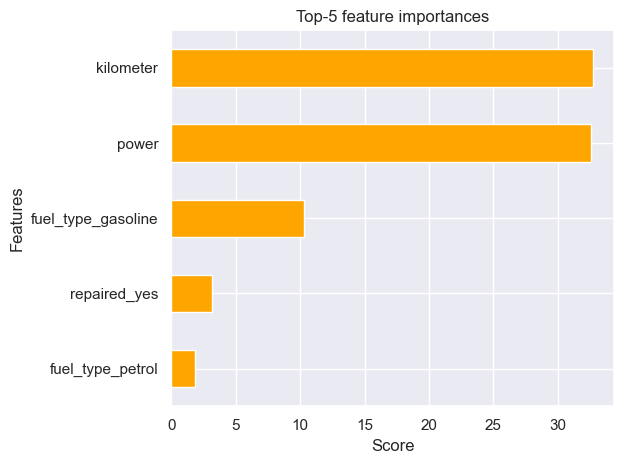

In [75]:
# Plotting feature importances
feature_importances = pd.Series(
    final_model["model"].feature_importances_,
    index=final_model["preprocessor"].get_feature_names_out(),
).sort_values()

feature_importances.tail().plot(kind="barh", color="orange")

plt.title("Top-5 feature importances")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

**Summary**

In this small section we have seen that `kilometer` and `power` features are particularly important when predicting car prices.

## Testing

Let's check the model for predictive quality and adequacy on the test set.

In [76]:
# Testing the final model
rmse_test = final_grid.compute_regression_stats(metric="rmse")
assert rmse_test < RMSE_THRESHOLD, "Model quality is insufficient"

print(f"Test score: {rmse_test:.4f}")

Test score: 2369.1868


In [77]:
# Comparing with dummy model
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(predictions_dummy, target_test, squared=False)

assert rmse_test < rmse_dummy, "Model is inadequate"

print("Model is adequate")

Model is adequate


The model passed all checks so we can now save the trained model in a file.

In [78]:
# Saving the final model
dump(final_model, "final_model_trained.joblib")

['final_model_trained.joblib']

## Final conclusion

This study was devoted to building and selecting the optimal model for determining the cost of the car. The data was uploaded, analyzed and visualized, as well as preprocessed. Moreover, the data was appropriately prepared using transformers and pipelines for machine learning algorithms and hyperparameter selection, as a result of which we were able to identify the optimal model that meets the customer's requirements.

In the process of searching for a model, two classes of models were considered: conventional machine learning models and gradient boosting models. Based on the results of a random search for optimal combinations of hyperparameters, the choice fell on the *CatBoostRegressor* model from the `catboost` library, which not only was able to pass the test for compliance with proper quality and sanity, but also showed good results in terms of speed and training time/predictions.